In [223]:
!pip install pandas==2.2.2
!pip install numpy==1.26.4
!pip install matplotlib==3.8.0
!pip install scikit-learn==1.5.0
!pip install torch==2.3.1
!pip install torchvision==0.18.1
!pip install optuna

Import Statements

In [249]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os
import random
import optuna

Custom Model

In [164]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, padding = 'same')
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, padding = 'same')
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, padding = 'same')
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Training Loop Function

In [179]:
def training_loop(model, training_dataloader, validation_dataloader, epochs, criterion, optimizer):
    training_results = {'Training Loss':[], 'Training Accuracy':[]}
    validation_results = {'Validation Loss':[], 'Validation Accuracy':[]}
    for i in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for x, y, in training_dataloader:
            optimizer.zero_grad()
            yhat = model(x)
            loss = criterion(yhat, y)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(yhat, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
            
        training_loss = running_loss/len(training_dataloader)
        training_accuracy = 100 * correct/total
        training_results['Training Loss'].append(training_loss)
        training_results['Training Accuracy'].append(training_accuracy)
        
        model.eval()
        validation_running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for x, y in validation_dataloader:
                yhat = model(x)
                loss = criterion(yhat, y)
                validation_running_loss += loss.item()
                _, predicted = torch.max(yhat, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
    
        validation_training_loss = validation_running_loss/len(validation_dataloader)
        validation_accuracy = 100 * correct/total
        validation_results['Validation Loss'].append(validation_training_loss)
        validation_results['Validation Accuracy'].append(validation_accuracy)
        print(f'Epoch {i+1}/{epochs}')

    print('')
    print('Training complete')
    return training_results, validation_results            

Original Dataset

In [93]:
training_transformations = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.ImageFolder(root = "Downloads/X-ray Imaging Dataset for Detecting Fractured vs. Non-Fractured Bones/Original Dataset", 
                               transform = training_transformations)

train_size = int(0.8 * len(dataset))
validation_size = int(len(dataset) - train_size)
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

train_dataloader = DataLoader(dataset = train_dataset, batch_size = 16, shuffle = True)
validation_dataloader = DataLoader(dataset = validation_dataset, batch_size = 16, shuffle = False)

Train model

In [168]:
model = CNN()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
epochs = 30
criterion = nn.CrossEntropyLoss()
training_results, validation_results = training_loop(model, train_dataloader, validation_dataloader, epochs, criterion, optimizer)

Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30


Plot performance

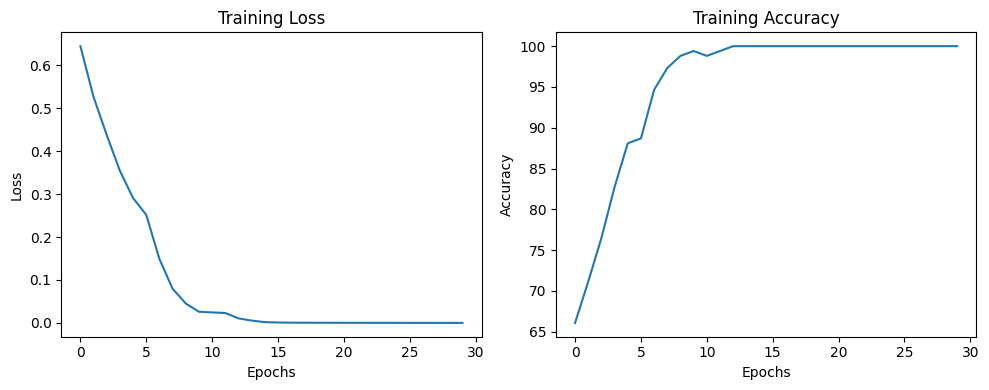

In [170]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (10, 4))
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].plot(training_results['Training Loss'])

axes[1].set_title('Training Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].plot(training_results['Training Accuracy'])
fig.tight_layout()
plt.show()

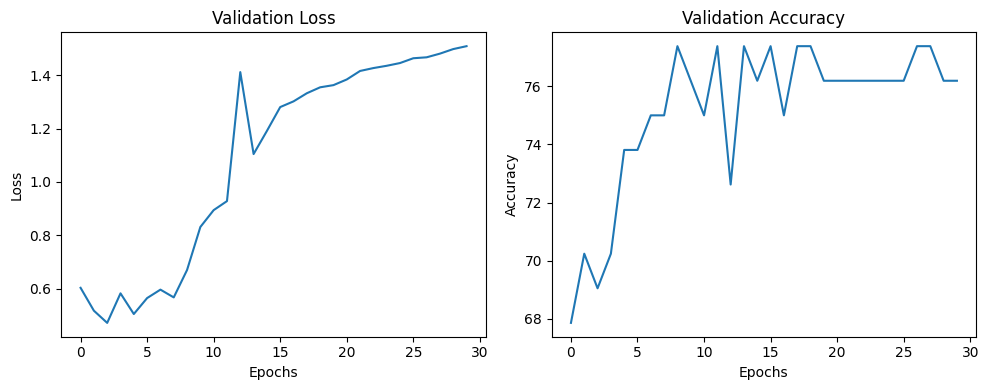

In [172]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (10, 4))
axes[0].set_title('Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].plot(validation_results['Validation Loss'])

axes[1].set_title('Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].plot(validation_results['Validation Accuracy'])
fig.tight_layout()
plt.show()

While the training accuracy approaches 100% and the loss steadily decreases, the validation accuracy plateaus around 76% and its loss rises, indicating that the model is overfitting to the training data. To counteract this issue, I will make use of data augmentation, synthetic data generation, and hyperparameter optimization.

Custom model with Batch normalization and Dropout

In [201]:
class updated_CNN(nn.Module):
    def __init__(self):
        super(updated_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, padding = 'same')
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, padding = 'same')
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, padding = 'same')
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc_bn = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc_bn(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

Augmented Dataset

In [197]:
augmented_transformations = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=5),
    transforms.RandomPerspective(distortion_scale=0.05, p=0.3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

validation_transformations = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0,5,), (0.5,))
])

class AugmentedDataset(Dataset):
    def __init__(self, root_dir, transform = None, augment_factor = 1):
        self.dataset = datasets.ImageFolder(root = root_dir)
        self.transform = transform
        self.augment_factor = augment_factor
        self.indices = []
        for idx in range(len(self.dataset)):
            self.indices.extend([idx] * augment_factor)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        img, label = self.dataset[real_idx]
        if self.transform:
            img = self.transform(img)
        return img, label

augmented_dataset = AugmentedDataset(root_dir = "Downloads/X-ray Imaging Dataset for Detecting Fractured vs. Non-Fractured Bones/Original Dataset", 
                                     transform = augmented_transformations, 
                                     augment_factor = 10)
train_size = int(0.8 * len(augmented_dataset))
validation_size = int(len(augmented_dataset) - train_size)
augmented_train_dataset, augmented_validation_dataset = random_split(augmented_dataset, [train_size, validation_size])
augmented_validation_dataset.trannsform = validation_transformations

augmented_training_dataloader = DataLoader(dataset = augmented_train_dataset, batch_size = 64, shuffle = True)
augmented_validation_dataloader = DataLoader(dataset = augmented_validation_dataset, batch_size = 64, shuffle = False)

Train updated model

In [208]:
model = updated_CNN()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
epochs = 30
criterion = nn.CrossEntropyLoss()
augmented_training_results, augmented_validation_results = training_loop(model, augmented_training_dataloader, augmented_validation_dataloader, epochs, criterion, optimizer)

Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30

Training complete


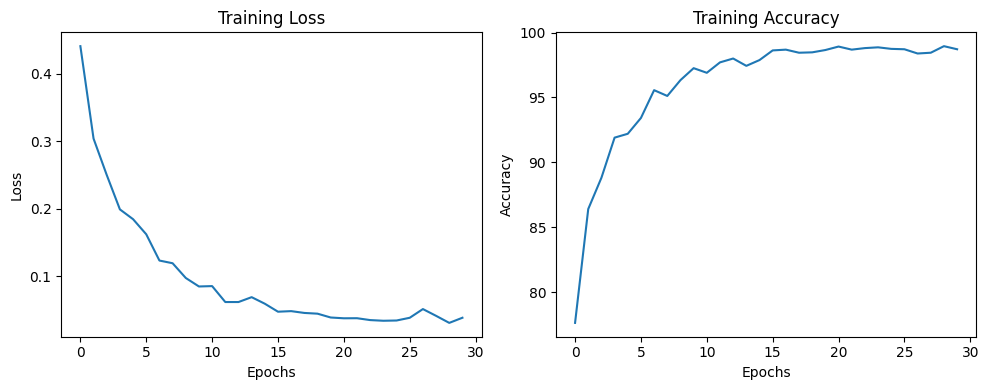

In [210]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (10, 4))
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].plot(augmented_training_results['Training Loss'])

axes[1].set_title('Training Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].plot(augmented_training_results['Training Accuracy'])
fig.tight_layout()
plt.show()

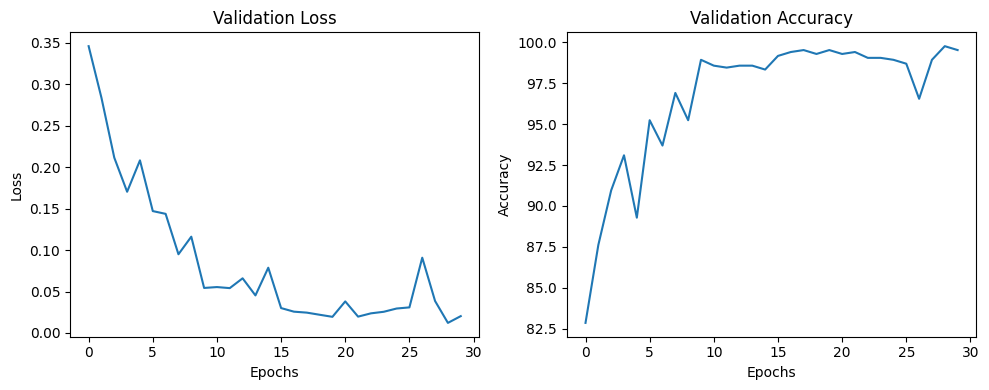

In [212]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (10, 4))
axes[0].set_title('Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].plot(augmented_validation_results['Validation Loss'])

axes[1].set_title('Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].plot(augmented_validation_results['Validation Accuracy'])
fig.tight_layout()
plt.show()

Custom model for hyperparameter tuning

In [235]:
class hyperparameter_CNN(nn.Module):
    def __init__(self, conv1_out, dropout_rate):
        super(hyperparameter_CNN, self).__init__()

        self.conv1_out = conv1_out
        self.conv2_out = self.conv1_out * 2
        self.conv3_out = self.conv2_out * 2
        
        self.conv1 = nn.Conv2d(1, self.conv1_out, kernel_size = 3, padding = 'same')
        self.bn1 = nn.BatchNorm2d(self.conv1_out)
        self.conv2 = nn.Conv2d(self.conv1_out, self.conv2_out, kernel_size = 3, padding = 'same')
        self.bn2 = nn.BatchNorm2d(self.conv2_out)
        self.conv3 = nn.Conv2d(self.conv2_out, self.conv3_out, kernel_size = 3, padding = 'same')
        self.bn3 = nn.BatchNorm2d(self.conv3_out)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(self.conv3_out * 16 * 16, 128)
        self.fc_bn = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc_bn(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [255]:
subset_size = 1000
train_subset = Subset(augmented_train_dataset, range(subset_size))
val_subset = Subset(augmented_validation_dataset, range(min(200, len(augmented_validation_dataset))))

In [257]:
def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_categorical('dropout', [0.3, 0.5, 0.7])
    conv1_out = trial.suggest_categorical('conv1_out', [16, 32, 64])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])


    train_loader = DataLoader(dataset = train_subset, batch_size = batch_size, shuffle = True)
    val_loader = DataLoader(dataset = val_subset, batch_size = batch_size, shuffle = False)

    model = hyperparameter_CNN(conv1_out, dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr = lr)
    criterion = nn.CrossEntropyLoss()

    best_val_accuracy = 0
    for epoch in range(5):
        model.train()
        for x, y in train_loader:
            optimizer.zero_grad()
            yhat = model(x)
            loss = criterion(yhat, y)
            loss.backward()
            optimizer.step()
            
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                yhat = model(x)
                _, prediction = torch.max(yhat, 1)
                correct += (prediction == y).sum().item()
                total += y.size(0)
        val_accuracy = correct/total

        trial.report(val_accuracy, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()
        
        best_val_accuracy = max(best_val_accuracy, val_accuracy)

    return best_val_accuracy

In [259]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 20)

print('Best trial:')
trial = study.best_trial
print(f'  Accuracy: {trial.value}')
print('  Parameters:')
for key, value in trial.param.items():
    print(f'    {key}: {value}')

[I 2025-08-26 15:30:52,542] A new study created in memory with name: no-name-39958a04-7cfe-4c3a-830f-59d5eee1e1f0
[I 2025-08-26 15:34:13,909] Trial 0 finished with value: 0.77 and parameters: {'lr': 1.0659029763706759e-05, 'dropout': 0.5, 'conv1_out': 64, 'batch_size': 32}. Best is trial 0 with value: 0.77.
[I 2025-08-26 15:35:52,680] Trial 1 finished with value: 0.8 and parameters: {'lr': 0.0005440742555579404, 'dropout': 0.5, 'conv1_out': 32, 'batch_size': 128}. Best is trial 1 with value: 0.8.
[I 2025-08-26 15:38:58,631] Trial 2 finished with value: 0.81 and parameters: {'lr': 0.000674378820112559, 'dropout': 0.7, 'conv1_out': 64, 'batch_size': 128}. Best is trial 2 with value: 0.81.
[I 2025-08-26 15:41:58,823] Trial 3 finished with value: 0.81 and parameters: {'lr': 0.0002834467567160566, 'dropout': 0.5, 'conv1_out': 64, 'batch_size': 128}. Best is trial 2 with value: 0.81.
[I 2025-08-26 15:43:38,361] Trial 4 finished with value: 0.855 and parameters: {'lr': 3.558764995679964e-05, 

Best trial:
  Accuracy: 0.865
  Parameters:


AttributeError: 'FrozenTrial' object has no attribute 'param'

In [263]:
lr = 8.159426862347275e-05
dropout = 0.3
conv1_out = 32
batch_size = 64
epochs = 30
model = hyperparameter_CNN(conv1_out, dropout)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)
train_loader = DataLoader(dataset = augmented_train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(dataset = augmented_validation_dataset, batch_size = batch_size, shuffle = False)

training_results, validation_results = training_loop(model, train_loader, val_loader, epochs, criterion, optimizer)

Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30

Training complete


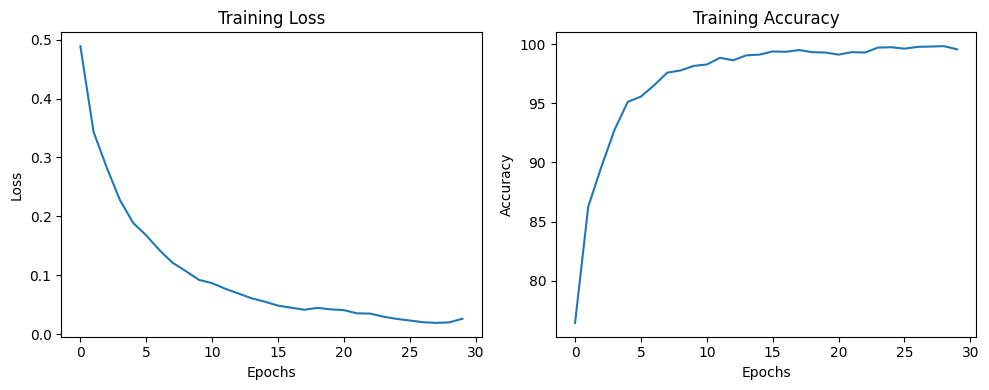

In [265]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (10, 4))
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].plot(training_results['Training Loss'])

axes[1].set_title('Training Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].plot(training_results['Training Accuracy'])
fig.tight_layout()
plt.show()

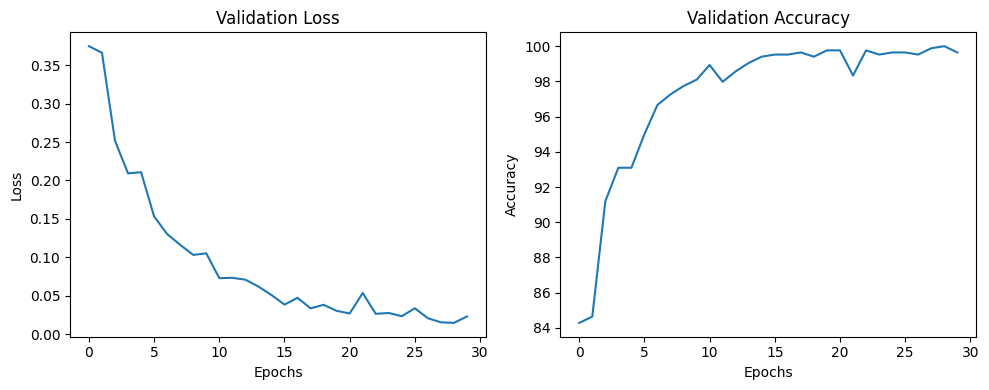

In [267]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (10, 4))
axes[0].set_title('Validation Loss')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].plot(validation_results['Validation Loss'])

axes[1].set_title('Validation Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].plot(validation_results['Validation Accuracy'])
fig.tight_layout()
plt.show()